In [58]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [59]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")


#config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)

In [60]:
#PARAMETERS
TIMEFRAME = "15m"
PAIR = "ETHUSDT"
BLOCK = 512
DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10
FROM_DATE = "2018-10-14 01:00:00" 
TO_DATE = "2022-10-05 01:00:00"
NUM_DATA = 10000 #max 100k
DATA_DIR = "data"
DUMP = 'csv'

path = os.path.join(DATA_DIR, PAIR); print(path)
if not os.path.exists(path):
    os.makedirs(path)

tk1 = os.path.join(PAIR, f"{BLOCK}_{FROM_DATE};{TIMEFRAME};{TO_DATE}")

path = os.path.join(DATA_DIR, tk1)
if not os.path.exists(path):
    os.makedirs(path)


data/ETHUSDT


In [61]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1500):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = dateparser.parse(from_date)
        self.to_date = dateparser.parse(to_date)
        self.from_ts = round(datetime.timestamp(self.from_date)*1000)
        self.to_ts = round(datetime.timestamp(self.to_date)*1000)
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.length = len(self.data)
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self):

        # self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit = self.limit))
        self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
        self.length = len(self.data)
        # print(self.data.iloc[-1]['open_time'])
        # pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms')
        # self.last_ts = round(datetime.timestamp(dateparser.parse(str(self.data.iloc[-1]['open_time'])))*1000)
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        print(self.to_ts, self.last_ts)
        print(type(self.to_ts), type(self.last_ts))
        print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
                # print(1)
                print(self.data.shape)
                self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
                self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))    
                self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
                self.length = len(self.data)
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        return df    



In [62]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)

/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [63]:
sdb.get_historical_klines()

1664942400000 1576200600000
<class 'int'> <class 'int'>
True
(3000, 11)
(4500, 11)
(6000, 11)
(7500, 11)
(9000, 11)


<AxesSubplot:>

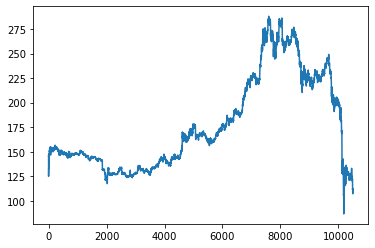

In [64]:
sdb.data.close.plot()

In [65]:
len(sdb.data)

10500

In [66]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-16 08:00:00,107.05,109.14,106.76,108.00,38437.609,2020-03-16 08:14:59.999,4.157823e+06,8393,19394.225,2.099121e+06
10496,2020-03-16 08:15:00,107.99,108.53,107.45,108.23,24743.625,2020-03-16 08:29:59.999,2.671772e+06,5581,12959.429,1.399735e+06
10497,2020-03-16 08:30:00,108.25,110.53,108.23,109.31,42978.487,2020-03-16 08:44:59.999,4.705737e+06,7541,22139.766,2.423849e+06
10498,2020-03-16 08:45:00,109.35,111.98,109.24,111.05,51522.249,2020-03-16 08:59:59.999,5.698695e+06,6288,28366.421,3.138639e+06


In [67]:
if DUMP == 'json':
    sdb.data.to_json(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == 'csv':
    sdb.data.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.csv"))    


In [68]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-16 08:00:00,107.05,109.14,106.76,108.00,38437.609,2020-03-16 08:14:59.999,4.157823e+06,8393,19394.225,2.099121e+06
10496,2020-03-16 08:15:00,107.99,108.53,107.45,108.23,24743.625,2020-03-16 08:29:59.999,2.671772e+06,5581,12959.429,1.399735e+06
10497,2020-03-16 08:30:00,108.25,110.53,108.23,109.31,42978.487,2020-03-16 08:44:59.999,4.705737e+06,7541,22139.766,2.423849e+06
10498,2020-03-16 08:45:00,109.35,111.98,109.24,111.05,51522.249,2020-03-16 08:59:59.999,5.698695e+06,6288,28366.421,3.138639e+06


In [69]:
process_klines(klines)

NameError: name 'process_klines' is not defined

/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


datetime.datetime(2021, 1, 1, 0, 0)

In [ ]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1500):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = dateparser.parse(from_date)
        self.to_date = dateparser.parse(to_date)
        self.from_ts = round(datetime.timestamp(self.from_date)*1000)
        self.to_ts = round(datetime.timestamp(self.to_date)*1000)
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self, from_date, to_date):
        
        self.from_date = dateparser.parse(from_date)
        self.to_date = dateparser.parse(to_date)
        self.from_ts = round(datetime.timestamp(self.from_date)*1000)
        self.to_ts = round(datetime.timestamp(self.to_date)*1000)
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.last_ts = round(datetime.timestamp(dateparser.parse(self.data.iloc[-1]['open_time']))*1000)
        while (len(self.data) < NUM_DATA) and \
            (self.data.iloc[-1,0] < self.to_ts):
                new_ts = self.data.iloc[-1,0]
                self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = from_date, endTime=to_date))    
    
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        return df    

# def process_klines(klines):

#     df = pd.DataFrame(klines)
#     df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
#     df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
#     df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
#     df['open'] = pd.to_numeric(df['open'])
#     df['high'] = pd.to_numeric(df['high'])
#     df['low'] = pd.to_numeric(df['low'])
#     df['close'] = pd.to_numeric(df['close'])
#     df['volume'] = pd.to_numeric(df['volume'])
#     df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
#     df['trades'] = pd.to_numeric(df['trades'])
#     df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
#     df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
#     df['ignore'] = pd.to_numeric(df['ignore'])
#     df.drop(['ignore'], axis=1, inplace=True)
#     return df

# StaticDatabase.process_klines = process_klines


/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


datetime.datetime(2021, 1, 1, 0, 0)

In [70]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME)

TypeError: StaticDatabase.__init__() missing 2 required positional arguments: 'from_date' and 'to_date'

In [71]:
sdb.get_historical_klines(dateparser.parse(FROM_DATE), dateparser.parse(TO_DATE))

/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


TypeError: StaticDatabase.get_historical_klines() takes 1 positional argument but 3 were given

In [72]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-16 08:00:00,107.05,109.14,106.76,108.00,38437.609,2020-03-16 08:14:59.999,4.157823e+06,8393,19394.225,2.099121e+06
10496,2020-03-16 08:15:00,107.99,108.53,107.45,108.23,24743.625,2020-03-16 08:29:59.999,2.671772e+06,5581,12959.429,1.399735e+06
10497,2020-03-16 08:30:00,108.25,110.53,108.23,109.31,42978.487,2020-03-16 08:44:59.999,4.705737e+06,7541,22139.766,2.423849e+06
10498,2020-03-16 08:45:00,109.35,111.98,109.24,111.05,51522.249,2020-03-16 08:59:59.999,5.698695e+06,6288,28366.421,3.138639e+06


In [73]:
df = sdb.data

In [74]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(177.59588637387728, 0.649658137880863)

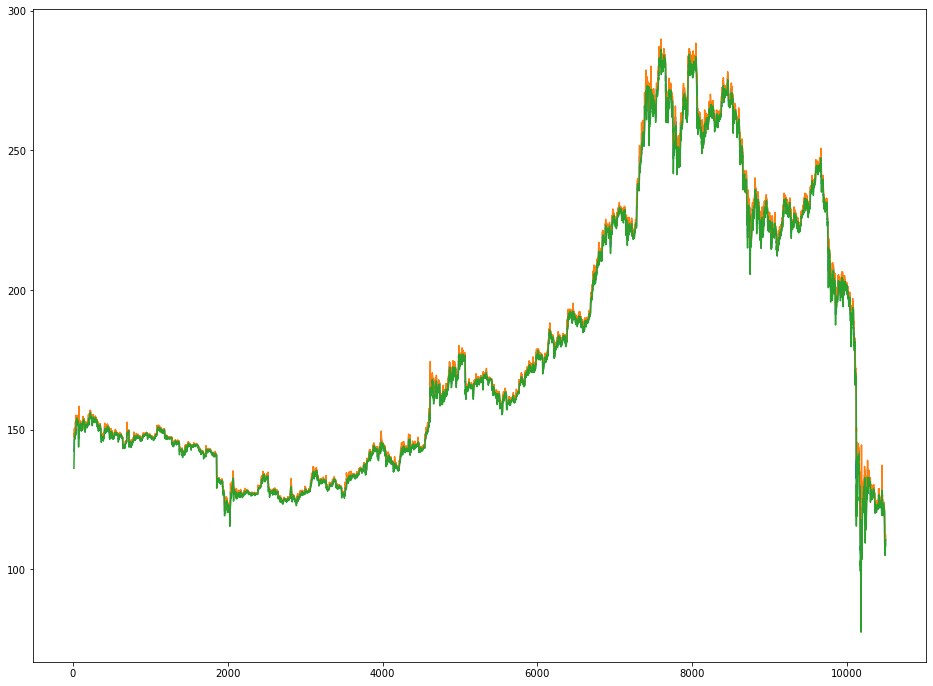

In [75]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [76]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[    3    31    50    68    75    77   100   128   201   224   259   288
   351   373   409   445   490   504   547   604   694   786   819   950
  1099  1322  1465  1492  1560  1721  1837  1878  1886  1926  1967  1983
  2017  2035  2041  2065  2070  2085  2111  2144  2166  2225  2438  2458
  2518  2607  2819  2851  2903  3003  3100  3107  3144  3206  3234  3269
  3374  3554  3569  3592  3715  3761  3831  3841  3884  3966  3982  4033
  4053  4072  4105  4155  4234  4244  4266  4272  4336  4353  4387  4458
  4581  4602  4616  4619  4622  4633  4643  4666  4683  4695  4711  4724
  4731  4762  4784  4797  4819  4828  4845  4857  4864  4869  4908  4922
  4931  4943  4970  4986  4992  4999  5019  5028  5037  5061  5089  5118
  5148  5210  5233  5271  5313  5341  5379  5440  5470  5507  5562  5582
  5635  5689  5793  5846  5872  5875  5904  5933  5945  5973  5988  6008
  6016  6040  6076  6101  6123  6134  6160  6165  6192  6202  6221  6229
  6255  6271  6291  6330  6386  6399  6405  6420  6

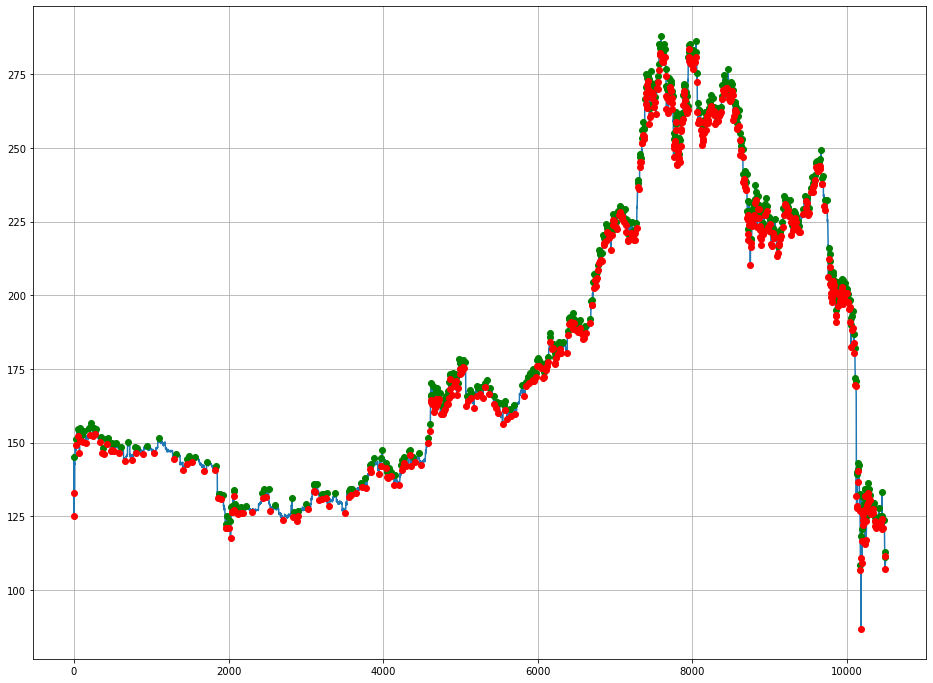

In [77]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [78]:
peak_regions = []
for peak_index in peak_indexes:

    peak_regions.append(peak_index)

    for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

        if peak_index+j >= len(df.close):
            break

        print(peak_index-j, peak_index+j)
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:

            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
    for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

3 3
2 4
31 31
30 32
29 33
28 34
27 35
50 50
49 51
48 52
47 53
46 54
68 68
67 69
66 70
65 71
64 72
75 75
74 76
73 77
72 78
71 79
77 77
76 78
75 79
74 80
73 81
100 100
99 101
98 102
97 103
96 104
128 128
127 129
126 130
125 131
124 132
201 201
200 202
199 203
198 204
197 205
224 224
223 225
222 226
221 227
220 228
259 259
258 260
257 261
256 262
255 263
288 288
287 289
286 290
285 291
284 292
351 351
350 352
349 353
348 354
347 355
373 373
372 374
371 375
370 376
369 377
409 409
408 410
407 411
406 412
405 413
445 445
444 446
443 447
442 448
441 449
490 490
489 491
488 492
487 493
486 494
504 504
503 505
502 506
501 507
500 508
547 547
546 548
545 549
544 550
543 551
604 604
603 605
602 606
601 607
600 608
694 694
693 695
692 696
691 697
690 698
786 786
785 787
784 788
783 789
782 790
819 819
818 820
817 821
816 822
815 823
950 950
949 951
948 952
947 953
946 954
1099 1099
1098 1100
1097 1101
1096 1102
1095 1103
1322 1322
1321 1323
1320 1324
1319 1325
1318 1326
1465 1465
1464 1466
1463 1

In [79]:
len(peak_regions) - len(peak_indexes)

740

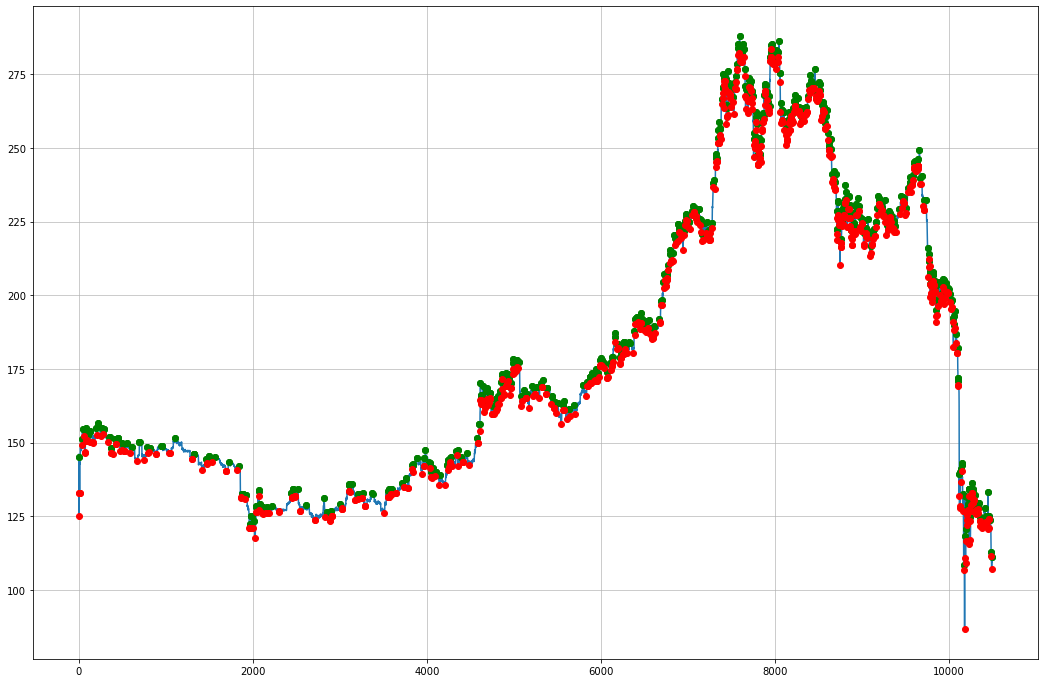

In [80]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


In [81]:
sdb.peak_regions

AttributeError: 'StaticDatabase' object has no attribute 'peak_regions'

In [82]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
print(labels[labels!=0].dropna())
    

       labels
2        -1.0
3         1.0
4        -1.0
5        -1.0
6        -1.0
...       ...
10474     1.0
10489    -1.0
10490     1.0
10494    -1.0
10498     1.0

[1446 rows x 1 columns]


In [83]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.460000e+00,1,0.000,0.000000e+00,0
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.000000e+00,0,0.000,0.000000e+00,0
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.250300e+00,1,0.000,0.000000e+00,-1
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.900000e+00,2,0.000,0.000000e+00,1
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.770100e+00,2,0.010,1.450100e+00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-16 08:00:00,107.05,109.14,106.76,108.00,38437.609,2020-03-16 08:14:59.999,4.157823e+06,8393,19394.225,2.099121e+06,0
10496,2020-03-16 08:15:00,107.99,108.53,107.45,108.23,24743.625,2020-03-16 08:29:59.999,2.671772e+06,5581,12959.429,1.399735e+06,0
10497,2020-03-16 08:30:00,108.25,110.53,108.23,109.31,42978.487,2020-03-16 08:44:59.999,4.705737e+06,7541,22139.766,2.423849e+06,0
10498,2020-03-16 08:45:00,109.35,111.98,109.24,111.05,51522.249,2020-03-16 08:59:59.999,5.698695e+06,6288,28366.421,3.138639e+06,1


In [84]:
features = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'labels']]
dates = features['open_time'].copy()
# timestamps = pd.to_datetime(features['open_time'], unit='ms')
# print(features['open_time'], type(timestamps), type(features['open_time']))
# features['open_time'] = timestamps
features.rename(columns={"open_time": "timestamp"}, inplace=True)

/tmp/ipykernel_154194/2604319273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns={"open_time": "timestamp"}, inplace=True)


In [85]:
features

,timestamp,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00,0
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00,0
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00,-1
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00,1
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00,-1
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-16 08:00:00,107.05,109.14,106.76,108.00,38437.609,4.157823e+06,8393,19394.225,2.099121e+06,0
10496,2020-03-16 08:15:00,107.99,108.53,107.45,108.23,24743.625,2.671772e+06,5581,12959.429,1.399735e+06,0
10497,2020-03-16 08:30:00,108.25,110.53,108.23,109.31,42978.487,4.705737e+06,7541,22139.766,2.423849e+06,0
10498,2020-03-16 08:45:00,109.35,111.98,109.24,111.05,51522.249,5.698695e+06,6288,28366.421,3.138639e+06,1


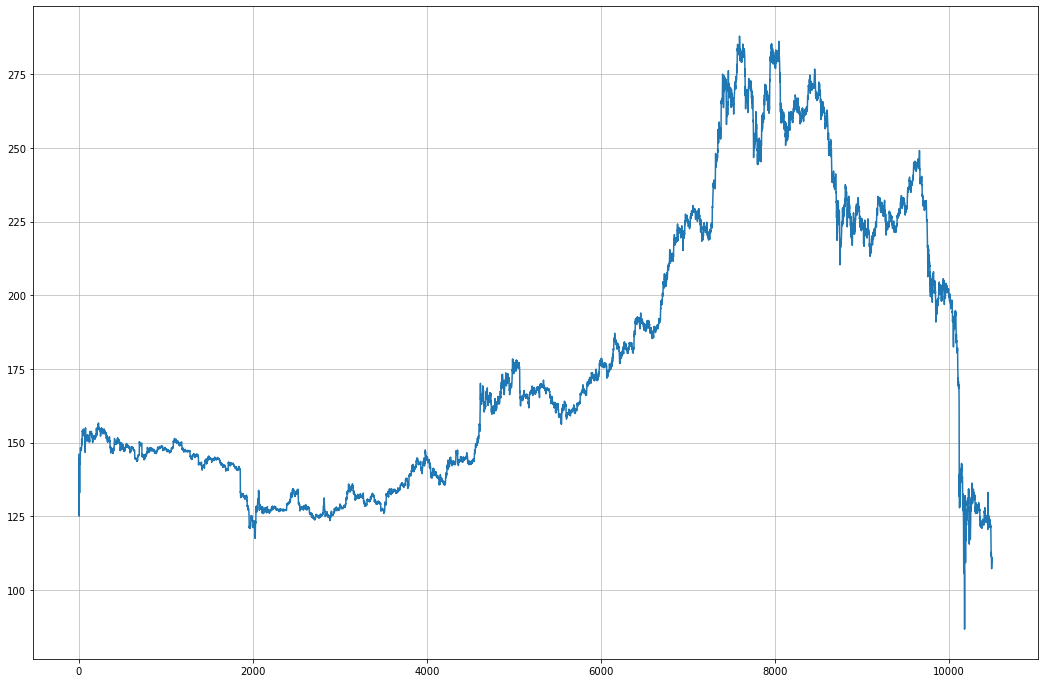

In [86]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)
none = []
for i, l in enumerate(labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = df.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = df.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.5, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [19]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class MarketDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs